# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

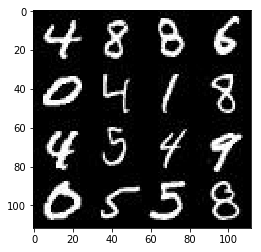

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

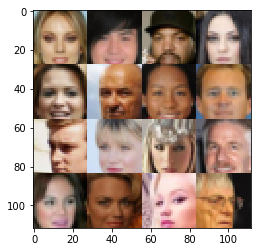

In [3]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def LeakyReLU(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # TODO: Implement Function
    # Using dropouts in discrimnator so as to weaken it's learning model for the data distribution 
    # as well as help generalise better.
    keep_probability = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 for MNIST or 28x28x3 for CelebA
        # This is the 1st layer
        # No batch normalization on first layer
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.nn.dropout(x1, keep_probability)
        relu1 = LeakyReLU(x1)
        # 14x14x128 now
        #print('discriminator x1 shape ', x1.shape)
        
        # This is the 2nd layer
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.nn.dropout(x2, keep_probability)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = LeakyReLU(bn2)
        # 7x7x256 now
        #print('discriminator x2 shape ', x2.shape)
        
        # This is the 3rd layer
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.nn.dropout(x3, keep_probability)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = LeakyReLU(bn3)
        # 4x4x512 now
        #print('discriminator x3 shape ', x3.shape)

        # This is the 4th fully-connected layer
        # Flatten it
        #flat = tf.reshape(relu2, (-1, 7*7*128)) before adding additional layer
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        logits = tf.nn.dropout(logits, keep_probability)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    keep_probability = 0.9 # eliminating dropout weakens generalization in Generator
    
    with tf.variable_scope('generator', reuse=not is_train): # <- not sure if reuse during training
        # 1st fully connected layer
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        #x1 = tf.nn.dropout(x1, keep_probability)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = LeakyReLU(x1)
        # 7x7x512 now
        
        # This is the 2nd layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x2 = tf.nn.dropout(x2, keep_probability)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = LeakyReLU(x2)
        # 14x14x256 now
        
        # This is the 3rd layer
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x3 = tf.nn.dropout(x3, keep_probability)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = LeakyReLU(x3)
        # 28x28x128 now
        
        # This is the 4th, output layer
        # stides=1 because no upscaling
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        #logits = tf.nn.dropout(logits, keep_probability)
        # 28x28xout_channel_dim now        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    #tf.reset_default_graph()
    # model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every=10
    show_every=100
    samples, losses = [], []
    steps=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # print(batch_images.shape) # <- (128, 28, 28, 1) for MNIST
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                # The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5
                #  of 28x28 dimensional images.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images}) saw suggestion to run 2x
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f} ...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    #show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    
        # show images at end of training
        #show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5076 ... Generator Loss: 0.6312
Epoch 1/2... Discriminator Loss: 0.6513 ... Generator Loss: 5.8129
Epoch 1/2... Discriminator Loss: 2.6161 ... Generator Loss: 1.4843
Epoch 1/2... Discriminator Loss: 2.3755 ... Generator Loss: 1.4483
Epoch 1/2... Discriminator Loss: 2.3375 ... Generator Loss: 3.0575
Epoch 1/2... Discriminator Loss: 1.9562 ... Generator Loss: 1.8201
Epoch 1/2... Discriminator Loss: 1.9231 ... Generator Loss: 1.9917
Epoch 1/2... Discriminator Loss: 1.8285 ... Generator Loss: 1.6666
Epoch 1/2... Discriminator Loss: 2.1843 ... Generator Loss: 1.5238
Epoch 1/2... Discriminator Loss: 1.8422 ... Generator Loss: 1.1711


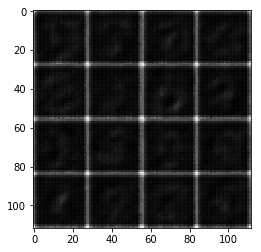

Epoch 1/2... Discriminator Loss: 2.0251 ... Generator Loss: 1.2521
Epoch 1/2... Discriminator Loss: 1.6461 ... Generator Loss: 0.6687
Epoch 1/2... Discriminator Loss: 1.4991 ... Generator Loss: 1.5382
Epoch 1/2... Discriminator Loss: 1.1346 ... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.6990 ... Generator Loss: 1.2407
Epoch 1/2... Discriminator Loss: 1.3586 ... Generator Loss: 1.0876
Epoch 1/2... Discriminator Loss: 1.3355 ... Generator Loss: 1.2463
Epoch 1/2... Discriminator Loss: 1.5070 ... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 1.5053 ... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.2380 ... Generator Loss: 1.0706


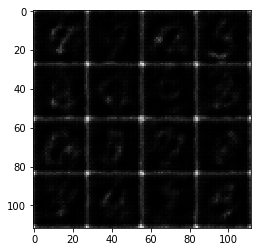

Epoch 1/2... Discriminator Loss: 1.2375 ... Generator Loss: 1.0146
Epoch 1/2... Discriminator Loss: 1.7945 ... Generator Loss: 1.3876
Epoch 1/2... Discriminator Loss: 1.2944 ... Generator Loss: 1.0321
Epoch 1/2... Discriminator Loss: 1.4096 ... Generator Loss: 1.5334
Epoch 1/2... Discriminator Loss: 1.5680 ... Generator Loss: 1.8687
Epoch 1/2... Discriminator Loss: 1.2090 ... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.2571 ... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 1.3554 ... Generator Loss: 0.5114
Epoch 1/2... Discriminator Loss: 1.3615 ... Generator Loss: 1.6580
Epoch 1/2... Discriminator Loss: 1.2963 ... Generator Loss: 1.1829


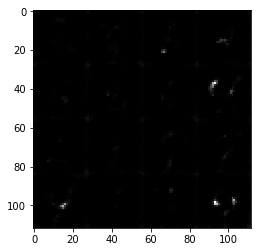

Epoch 1/2... Discriminator Loss: 1.2812 ... Generator Loss: 0.7339
Epoch 1/2... Discriminator Loss: 1.3613 ... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.0540 ... Generator Loss: 1.1797
Epoch 1/2... Discriminator Loss: 1.4226 ... Generator Loss: 0.5294
Epoch 1/2... Discriminator Loss: 1.4952 ... Generator Loss: 0.4254
Epoch 1/2... Discriminator Loss: 1.3552 ... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.3093 ... Generator Loss: 1.1506
Epoch 1/2... Discriminator Loss: 1.1854 ... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 1.1220 ... Generator Loss: 1.7248
Epoch 1/2... Discriminator Loss: 1.3387 ... Generator Loss: 1.6133


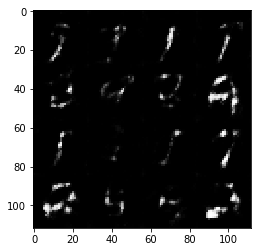

Epoch 1/2... Discriminator Loss: 1.1937 ... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 1.3349 ... Generator Loss: 1.5135
Epoch 1/2... Discriminator Loss: 1.6538 ... Generator Loss: 0.4978
Epoch 1/2... Discriminator Loss: 1.3898 ... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.2961 ... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.3907 ... Generator Loss: 0.6451
Epoch 1/2... Discriminator Loss: 1.3157 ... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 1.5398 ... Generator Loss: 1.9307
Epoch 1/2... Discriminator Loss: 1.1108 ... Generator Loss: 1.0666
Epoch 1/2... Discriminator Loss: 1.4235 ... Generator Loss: 0.4614


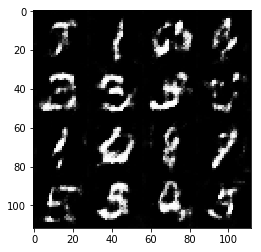

Epoch 1/2... Discriminator Loss: 1.1892 ... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.4448 ... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 1.2605 ... Generator Loss: 1.1370
Epoch 1/2... Discriminator Loss: 1.1784 ... Generator Loss: 1.5540
Epoch 1/2... Discriminator Loss: 1.2710 ... Generator Loss: 1.2431
Epoch 1/2... Discriminator Loss: 2.1337 ... Generator Loss: 0.3001
Epoch 1/2... Discriminator Loss: 1.4570 ... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 1.0425 ... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 1.5347 ... Generator Loss: 0.4906
Epoch 1/2... Discriminator Loss: 1.2830 ... Generator Loss: 1.0820


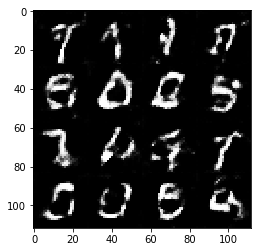

Epoch 1/2... Discriminator Loss: 1.0528 ... Generator Loss: 1.2664
Epoch 1/2... Discriminator Loss: 1.4273 ... Generator Loss: 1.6256
Epoch 1/2... Discriminator Loss: 1.3269 ... Generator Loss: 1.2914
Epoch 1/2... Discriminator Loss: 1.1900 ... Generator Loss: 1.3516
Epoch 1/2... Discriminator Loss: 1.0365 ... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 2.2882 ... Generator Loss: 0.2433
Epoch 1/2... Discriminator Loss: 0.9987 ... Generator Loss: 1.1568
Epoch 1/2... Discriminator Loss: 1.3009 ... Generator Loss: 1.4313
Epoch 1/2... Discriminator Loss: 1.2920 ... Generator Loss: 1.0838
Epoch 1/2... Discriminator Loss: 1.3537 ... Generator Loss: 1.4441


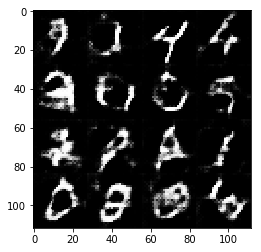

Epoch 1/2... Discriminator Loss: 0.9380 ... Generator Loss: 1.3850
Epoch 1/2... Discriminator Loss: 1.4776 ... Generator Loss: 2.0758
Epoch 1/2... Discriminator Loss: 1.7140 ... Generator Loss: 0.3546
Epoch 1/2... Discriminator Loss: 1.4212 ... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.3857 ... Generator Loss: 0.5502
Epoch 1/2... Discriminator Loss: 1.1646 ... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.2781 ... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.9211 ... Generator Loss: 0.3452
Epoch 1/2... Discriminator Loss: 1.3284 ... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 1.1020 ... Generator Loss: 0.7950


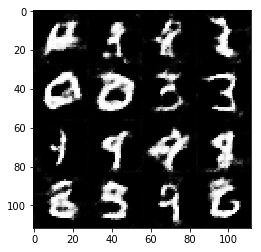

Epoch 1/2... Discriminator Loss: 1.3558 ... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 1.4654 ... Generator Loss: 0.5042
Epoch 1/2... Discriminator Loss: 1.1822 ... Generator Loss: 1.2225
Epoch 1/2... Discriminator Loss: 1.2077 ... Generator Loss: 0.7616
Epoch 1/2... Discriminator Loss: 1.0810 ... Generator Loss: 1.2526
Epoch 1/2... Discriminator Loss: 1.2856 ... Generator Loss: 1.0167
Epoch 1/2... Discriminator Loss: 1.2095 ... Generator Loss: 1.7938
Epoch 1/2... Discriminator Loss: 0.9519 ... Generator Loss: 1.3691
Epoch 1/2... Discriminator Loss: 1.1873 ... Generator Loss: 1.6119
Epoch 1/2... Discriminator Loss: 1.2973 ... Generator Loss: 0.8572


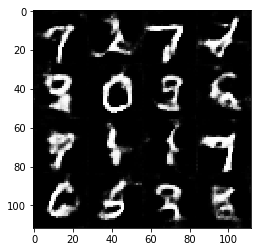

Epoch 1/2... Discriminator Loss: 1.3100 ... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 1.6640 ... Generator Loss: 0.5327
Epoch 1/2... Discriminator Loss: 1.4373 ... Generator Loss: 0.5231
Epoch 1/2... Discriminator Loss: 1.5660 ... Generator Loss: 0.3548
Epoch 1/2... Discriminator Loss: 1.2212 ... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.1009 ... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 0.9422 ... Generator Loss: 1.2459
Epoch 1/2... Discriminator Loss: 1.2013 ... Generator Loss: 1.5068
Epoch 1/2... Discriminator Loss: 0.8740 ... Generator Loss: 1.9486
Epoch 1/2... Discriminator Loss: 1.2077 ... Generator Loss: 1.3344


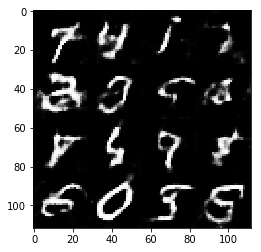

Epoch 1/2... Discriminator Loss: 1.3032 ... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.2500 ... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.1677 ... Generator Loss: 0.6624
Epoch 1/2... Discriminator Loss: 1.6733 ... Generator Loss: 0.4182
Epoch 1/2... Discriminator Loss: 1.3806 ... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 1.2093 ... Generator Loss: 1.4811
Epoch 1/2... Discriminator Loss: 1.4949 ... Generator Loss: 1.1268
Epoch 1/2... Discriminator Loss: 1.6157 ... Generator Loss: 0.4424
Epoch 1/2... Discriminator Loss: 1.1586 ... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.2252 ... Generator Loss: 0.6268


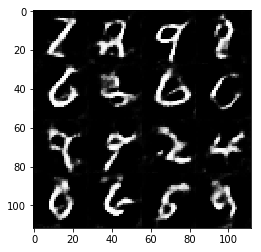

Epoch 1/2... Discriminator Loss: 1.3447 ... Generator Loss: 1.1988
Epoch 1/2... Discriminator Loss: 1.3157 ... Generator Loss: 0.8906
Epoch 1/2... Discriminator Loss: 1.1074 ... Generator Loss: 0.9602
Epoch 1/2... Discriminator Loss: 1.5146 ... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.5050 ... Generator Loss: 0.4097
Epoch 1/2... Discriminator Loss: 1.1573 ... Generator Loss: 1.0500
Epoch 1/2... Discriminator Loss: 1.3248 ... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.2826 ... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.4521 ... Generator Loss: 1.7079
Epoch 1/2... Discriminator Loss: 1.2308 ... Generator Loss: 0.6936


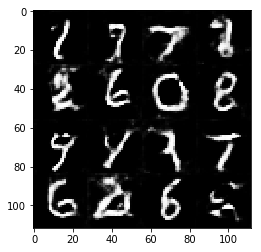

Epoch 1/2... Discriminator Loss: 1.2588 ... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.3412 ... Generator Loss: 0.8659
Epoch 1/2... Discriminator Loss: 1.2885 ... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 1.3009 ... Generator Loss: 0.7122
Epoch 1/2... Discriminator Loss: 1.1798 ... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.2733 ... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.0631 ... Generator Loss: 0.7020
Epoch 1/2... Discriminator Loss: 1.2668 ... Generator Loss: 0.9828
Epoch 1/2... Discriminator Loss: 1.3338 ... Generator Loss: 1.3087
Epoch 1/2... Discriminator Loss: 1.3039 ... Generator Loss: 1.1112


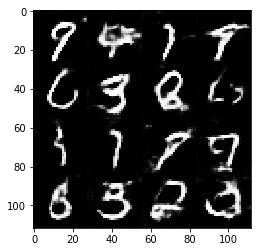

Epoch 1/2... Discriminator Loss: 1.4106 ... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 1.2347 ... Generator Loss: 1.0757
Epoch 1/2... Discriminator Loss: 1.2107 ... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.3079 ... Generator Loss: 1.1272
Epoch 1/2... Discriminator Loss: 1.0586 ... Generator Loss: 1.0581
Epoch 1/2... Discriminator Loss: 1.1992 ... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 1.4694 ... Generator Loss: 1.6928
Epoch 1/2... Discriminator Loss: 1.1870 ... Generator Loss: 1.0030
Epoch 1/2... Discriminator Loss: 1.0539 ... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.2908 ... Generator Loss: 0.8410


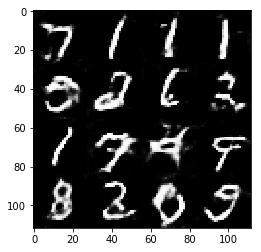

Epoch 1/2... Discriminator Loss: 1.1731 ... Generator Loss: 0.6375
Epoch 1/2... Discriminator Loss: 1.4091 ... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.3209 ... Generator Loss: 1.4441
Epoch 1/2... Discriminator Loss: 1.3334 ... Generator Loss: 1.1731
Epoch 1/2... Discriminator Loss: 1.5980 ... Generator Loss: 1.1005
Epoch 1/2... Discriminator Loss: 1.6153 ... Generator Loss: 0.4085
Epoch 1/2... Discriminator Loss: 1.3398 ... Generator Loss: 0.4733
Epoch 1/2... Discriminator Loss: 1.7322 ... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 1.2960 ... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 1.2304 ... Generator Loss: 0.8437


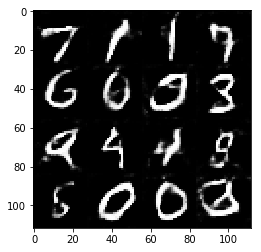

Epoch 1/2... Discriminator Loss: 1.3319 ... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.4152 ... Generator Loss: 0.4609
Epoch 1/2... Discriminator Loss: 1.3194 ... Generator Loss: 0.6479
Epoch 1/2... Discriminator Loss: 1.3389 ... Generator Loss: 1.3054
Epoch 1/2... Discriminator Loss: 1.4737 ... Generator Loss: 1.3531
Epoch 1/2... Discriminator Loss: 1.4899 ... Generator Loss: 0.4873
Epoch 1/2... Discriminator Loss: 1.3090 ... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 1.3933 ... Generator Loss: 0.6188
Epoch 1/2... Discriminator Loss: 1.1461 ... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 1.3302 ... Generator Loss: 0.6394


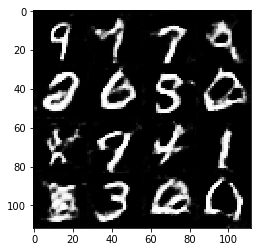

Epoch 1/2... Discriminator Loss: 1.3445 ... Generator Loss: 0.6382
Epoch 1/2... Discriminator Loss: 1.1980 ... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.3582 ... Generator Loss: 0.8466
Epoch 1/2... Discriminator Loss: 1.4027 ... Generator Loss: 0.5972
Epoch 1/2... Discriminator Loss: 1.2370 ... Generator Loss: 1.0533
Epoch 1/2... Discriminator Loss: 1.3421 ... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.3459 ... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.4069 ... Generator Loss: 0.6222
Epoch 1/2... Discriminator Loss: 1.2992 ... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 1.3153 ... Generator Loss: 0.5529


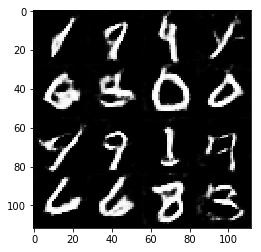

Epoch 1/2... Discriminator Loss: 1.3275 ... Generator Loss: 1.3490
Epoch 1/2... Discriminator Loss: 1.5413 ... Generator Loss: 0.5176
Epoch 1/2... Discriminator Loss: 1.1989 ... Generator Loss: 0.8320
Epoch 1/2... Discriminator Loss: 1.3104 ... Generator Loss: 0.5334
Epoch 1/2... Discriminator Loss: 1.2699 ... Generator Loss: 0.9803
Epoch 1/2... Discriminator Loss: 1.4103 ... Generator Loss: 1.1538
Epoch 1/2... Discriminator Loss: 1.6626 ... Generator Loss: 0.4336
Epoch 1/2... Discriminator Loss: 1.1547 ... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.2330 ... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.3147 ... Generator Loss: 1.4446


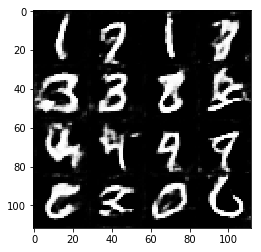

Epoch 1/2... Discriminator Loss: 1.3329 ... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 1.2248 ... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.7517 ... Generator Loss: 0.3887
Epoch 1/2... Discriminator Loss: 1.3140 ... Generator Loss: 0.6107
Epoch 1/2... Discriminator Loss: 1.4245 ... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.1544 ... Generator Loss: 0.9459
Epoch 1/2... Discriminator Loss: 1.2479 ... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.2472 ... Generator Loss: 0.6706
Epoch 2/2... Discriminator Loss: 1.3224 ... Generator Loss: 0.8828
Epoch 2/2... Discriminator Loss: 1.2761 ... Generator Loss: 1.3795


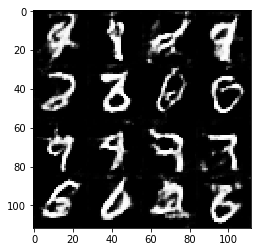

Epoch 2/2... Discriminator Loss: 1.4478 ... Generator Loss: 0.4091
Epoch 2/2... Discriminator Loss: 1.1294 ... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 1.2762 ... Generator Loss: 1.4025
Epoch 2/2... Discriminator Loss: 1.5164 ... Generator Loss: 0.5821
Epoch 2/2... Discriminator Loss: 1.4005 ... Generator Loss: 0.6012
Epoch 2/2... Discriminator Loss: 1.2826 ... Generator Loss: 0.6148
Epoch 2/2... Discriminator Loss: 1.3191 ... Generator Loss: 0.5677
Epoch 2/2... Discriminator Loss: 1.3110 ... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 1.4088 ... Generator Loss: 0.5776
Epoch 2/2... Discriminator Loss: 1.3794 ... Generator Loss: 0.5724


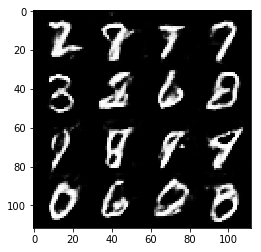

Epoch 2/2... Discriminator Loss: 1.3285 ... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 1.7337 ... Generator Loss: 0.3876
Epoch 2/2... Discriminator Loss: 1.3987 ... Generator Loss: 1.0630
Epoch 2/2... Discriminator Loss: 1.3869 ... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 1.3809 ... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 1.2809 ... Generator Loss: 0.5503
Epoch 2/2... Discriminator Loss: 1.5065 ... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: 1.2522 ... Generator Loss: 0.5220
Epoch 2/2... Discriminator Loss: 1.4916 ... Generator Loss: 0.4600
Epoch 2/2... Discriminator Loss: 1.3577 ... Generator Loss: 0.5518


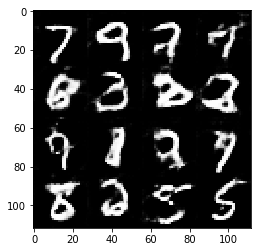

Epoch 2/2... Discriminator Loss: 1.4473 ... Generator Loss: 0.5469
Epoch 2/2... Discriminator Loss: 1.4145 ... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.2510 ... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 1.2823 ... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 1.4869 ... Generator Loss: 1.6272
Epoch 2/2... Discriminator Loss: 1.2774 ... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 1.3121 ... Generator Loss: 1.4018
Epoch 2/2... Discriminator Loss: 1.2204 ... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 1.2344 ... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.2454 ... Generator Loss: 0.5381


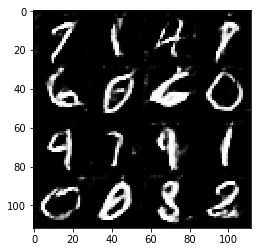

Epoch 2/2... Discriminator Loss: 1.3137 ... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.1934 ... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 1.4470 ... Generator Loss: 0.5015
Epoch 2/2... Discriminator Loss: 1.3343 ... Generator Loss: 0.6792
Epoch 2/2... Discriminator Loss: 1.2202 ... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.2770 ... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.4779 ... Generator Loss: 1.4884
Epoch 2/2... Discriminator Loss: 1.3056 ... Generator Loss: 0.5062
Epoch 2/2... Discriminator Loss: 1.3262 ... Generator Loss: 1.2323
Epoch 2/2... Discriminator Loss: 1.2403 ... Generator Loss: 1.2779


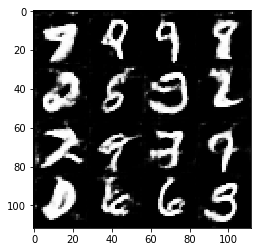

Epoch 2/2... Discriminator Loss: 1.1442 ... Generator Loss: 1.2317
Epoch 2/2... Discriminator Loss: 1.2759 ... Generator Loss: 1.1175
Epoch 2/2... Discriminator Loss: 1.3225 ... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 1.2895 ... Generator Loss: 0.8215
Epoch 2/2... Discriminator Loss: 1.2554 ... Generator Loss: 0.6884
Epoch 2/2... Discriminator Loss: 1.3534 ... Generator Loss: 0.7801
Epoch 2/2... Discriminator Loss: 1.0661 ... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 1.4598 ... Generator Loss: 0.9987
Epoch 2/2... Discriminator Loss: 1.2031 ... Generator Loss: 1.0035
Epoch 2/2... Discriminator Loss: 1.2952 ... Generator Loss: 1.2663


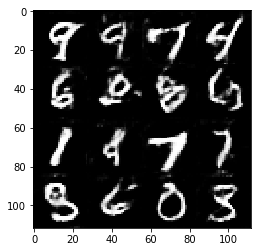

Epoch 2/2... Discriminator Loss: 1.4013 ... Generator Loss: 0.5447
Epoch 2/2... Discriminator Loss: 1.3045 ... Generator Loss: 0.6877
Epoch 2/2... Discriminator Loss: 1.3719 ... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 1.1949 ... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.1737 ... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.3476 ... Generator Loss: 0.8559
Epoch 2/2... Discriminator Loss: 1.2054 ... Generator Loss: 0.9417
Epoch 2/2... Discriminator Loss: 1.5512 ... Generator Loss: 0.4615
Epoch 2/2... Discriminator Loss: 1.3957 ... Generator Loss: 0.6065
Epoch 2/2... Discriminator Loss: 1.2536 ... Generator Loss: 0.6354


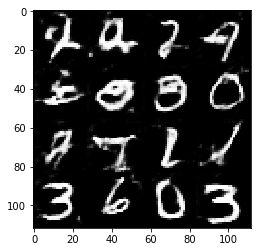

Epoch 2/2... Discriminator Loss: 1.4914 ... Generator Loss: 0.5497
Epoch 2/2... Discriminator Loss: 1.2707 ... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 1.0789 ... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.4553 ... Generator Loss: 0.5000
Epoch 2/2... Discriminator Loss: 1.0998 ... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 1.5853 ... Generator Loss: 0.4601
Epoch 2/2... Discriminator Loss: 1.2075 ... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 1.1625 ... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 1.2577 ... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 0.9827 ... Generator Loss: 0.9655


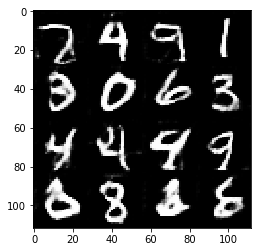

Epoch 2/2... Discriminator Loss: 1.6382 ... Generator Loss: 1.6996
Epoch 2/2... Discriminator Loss: 1.1543 ... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.3489 ... Generator Loss: 1.0073
Epoch 2/2... Discriminator Loss: 1.4241 ... Generator Loss: 1.0823
Epoch 2/2... Discriminator Loss: 1.6580 ... Generator Loss: 0.4177
Epoch 2/2... Discriminator Loss: 1.2833 ... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 1.2687 ... Generator Loss: 0.6413
Epoch 2/2... Discriminator Loss: 1.2679 ... Generator Loss: 0.9529
Epoch 2/2... Discriminator Loss: 1.1767 ... Generator Loss: 0.9712
Epoch 2/2... Discriminator Loss: 1.3435 ... Generator Loss: 0.7483


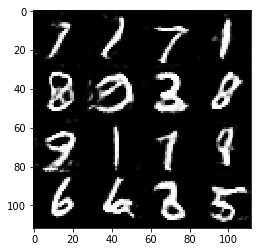

Epoch 2/2... Discriminator Loss: 1.1996 ... Generator Loss: 1.2862
Epoch 2/2... Discriminator Loss: 1.3245 ... Generator Loss: 1.0640
Epoch 2/2... Discriminator Loss: 1.3054 ... Generator Loss: 1.2040
Epoch 2/2... Discriminator Loss: 1.3836 ... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 1.1576 ... Generator Loss: 0.9331
Epoch 2/2... Discriminator Loss: 1.2383 ... Generator Loss: 0.7415
Epoch 2/2... Discriminator Loss: 1.1869 ... Generator Loss: 0.7769
Epoch 2/2... Discriminator Loss: 1.2624 ... Generator Loss: 0.7755
Epoch 2/2... Discriminator Loss: 1.2034 ... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 1.5947 ... Generator Loss: 0.4628


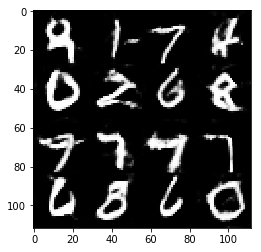

Epoch 2/2... Discriminator Loss: 1.5499 ... Generator Loss: 0.4465
Epoch 2/2... Discriminator Loss: 1.3262 ... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 1.1973 ... Generator Loss: 0.7836
Epoch 2/2... Discriminator Loss: 1.3155 ... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 1.2686 ... Generator Loss: 1.3475
Epoch 2/2... Discriminator Loss: 1.2859 ... Generator Loss: 1.0666
Epoch 2/2... Discriminator Loss: 1.3112 ... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.6403 ... Generator Loss: 0.4020
Epoch 2/2... Discriminator Loss: 1.1031 ... Generator Loss: 1.0910
Epoch 2/2... Discriminator Loss: 1.4330 ... Generator Loss: 0.4769


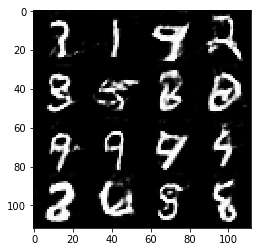

Epoch 2/2... Discriminator Loss: 1.0187 ... Generator Loss: 1.0727
Epoch 2/2... Discriminator Loss: 1.4524 ... Generator Loss: 0.4577
Epoch 2/2... Discriminator Loss: 1.4540 ... Generator Loss: 0.4321
Epoch 2/2... Discriminator Loss: 1.4080 ... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.5220 ... Generator Loss: 0.4263
Epoch 2/2... Discriminator Loss: 1.4376 ... Generator Loss: 0.5887
Epoch 2/2... Discriminator Loss: 1.2290 ... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.5195 ... Generator Loss: 0.4889
Epoch 2/2... Discriminator Loss: 1.4403 ... Generator Loss: 0.4420
Epoch 2/2... Discriminator Loss: 1.1397 ... Generator Loss: 1.0417


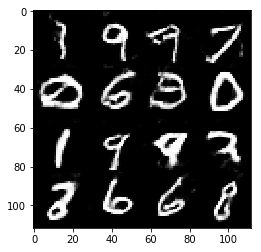

Epoch 2/2... Discriminator Loss: 1.3503 ... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.3751 ... Generator Loss: 0.8200
Epoch 2/2... Discriminator Loss: 1.3633 ... Generator Loss: 0.6416
Epoch 2/2... Discriminator Loss: 1.2450 ... Generator Loss: 0.9683
Epoch 2/2... Discriminator Loss: 1.1781 ... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 1.0854 ... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 1.2883 ... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 1.5142 ... Generator Loss: 0.4476
Epoch 2/2... Discriminator Loss: 1.1044 ... Generator Loss: 0.8322
Epoch 2/2... Discriminator Loss: 1.5471 ... Generator Loss: 0.4713


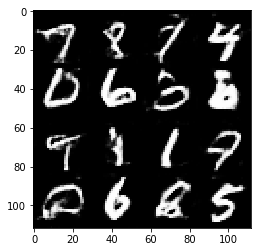

Epoch 2/2... Discriminator Loss: 1.3492 ... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 1.2044 ... Generator Loss: 1.2709
Epoch 2/2... Discriminator Loss: 1.3104 ... Generator Loss: 0.7665
Epoch 2/2... Discriminator Loss: 1.3546 ... Generator Loss: 1.0059
Epoch 2/2... Discriminator Loss: 1.5092 ... Generator Loss: 0.4607
Epoch 2/2... Discriminator Loss: 1.3099 ... Generator Loss: 0.6461
Epoch 2/2... Discriminator Loss: 1.4078 ... Generator Loss: 0.4719
Epoch 2/2... Discriminator Loss: 1.6344 ... Generator Loss: 0.4452
Epoch 2/2... Discriminator Loss: 1.3049 ... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.2792 ... Generator Loss: 0.8721


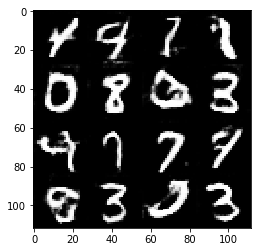

Epoch 2/2... Discriminator Loss: 1.1815 ... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.3323 ... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.4148 ... Generator Loss: 0.3825
Epoch 2/2... Discriminator Loss: 1.1044 ... Generator Loss: 1.1794
Epoch 2/2... Discriminator Loss: 1.3562 ... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.5816 ... Generator Loss: 0.4088
Epoch 2/2... Discriminator Loss: 1.2934 ... Generator Loss: 0.9383
Epoch 2/2... Discriminator Loss: 1.3580 ... Generator Loss: 0.9224
Epoch 2/2... Discriminator Loss: 1.3975 ... Generator Loss: 0.6831
Epoch 2/2... Discriminator Loss: 1.5348 ... Generator Loss: 1.0541


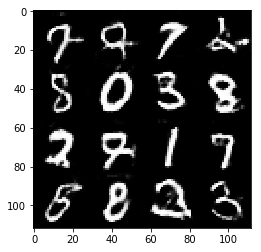

Epoch 2/2... Discriminator Loss: 1.4284 ... Generator Loss: 0.5402
Epoch 2/2... Discriminator Loss: 1.4119 ... Generator Loss: 0.5868
Epoch 2/2... Discriminator Loss: 1.5861 ... Generator Loss: 0.4480
Epoch 2/2... Discriminator Loss: 1.1350 ... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 1.3655 ... Generator Loss: 1.2900
Epoch 2/2... Discriminator Loss: 1.2690 ... Generator Loss: 0.7284
Epoch 2/2... Discriminator Loss: 1.4266 ... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 1.3678 ... Generator Loss: 0.8423
Epoch 2/2... Discriminator Loss: 1.2320 ... Generator Loss: 0.5824
Epoch 2/2... Discriminator Loss: 1.2073 ... Generator Loss: 0.9524


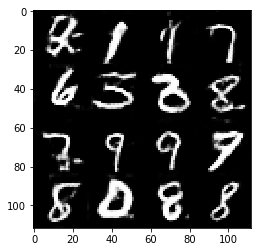

Epoch 2/2... Discriminator Loss: 1.3245 ... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 1.2499 ... Generator Loss: 1.3792
Epoch 2/2... Discriminator Loss: 1.1719 ... Generator Loss: 0.8636
Epoch 2/2... Discriminator Loss: 1.1810 ... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 1.2058 ... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 1.2982 ... Generator Loss: 0.5655
Epoch 2/2... Discriminator Loss: 1.4061 ... Generator Loss: 0.4827
Epoch 2/2... Discriminator Loss: 1.3518 ... Generator Loss: 0.5718
Epoch 2/2... Discriminator Loss: 1.4187 ... Generator Loss: 1.4035
Epoch 2/2... Discriminator Loss: 1.3968 ... Generator Loss: 0.6270


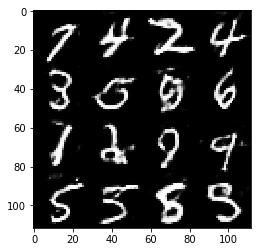

Epoch 2/2... Discriminator Loss: 1.1933 ... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.1669 ... Generator Loss: 0.7724
Epoch 2/2... Discriminator Loss: 1.1621 ... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 1.3753 ... Generator Loss: 0.5926
Epoch 2/2... Discriminator Loss: 1.2869 ... Generator Loss: 1.1004
Epoch 2/2... Discriminator Loss: 1.3356 ... Generator Loss: 0.5856
Epoch 2/2... Discriminator Loss: 1.2295 ... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.4375 ... Generator Loss: 0.4789
Epoch 2/2... Discriminator Loss: 1.2314 ... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 1.2644 ... Generator Loss: 0.6185


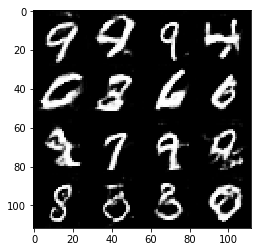

Epoch 2/2... Discriminator Loss: 1.1606 ... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 1.1393 ... Generator Loss: 1.2371
Epoch 2/2... Discriminator Loss: 1.2873 ... Generator Loss: 1.9707
Epoch 2/2... Discriminator Loss: 1.2666 ... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 1.3535 ... Generator Loss: 0.5475
Epoch 2/2... Discriminator Loss: 1.4356 ... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 1.1400 ... Generator Loss: 0.8043
Epoch 2/2... Discriminator Loss: 1.3198 ... Generator Loss: 0.9430
Epoch 2/2... Discriminator Loss: 1.1705 ... Generator Loss: 1.1680
Epoch 2/2... Discriminator Loss: 1.2704 ... Generator Loss: 0.7232


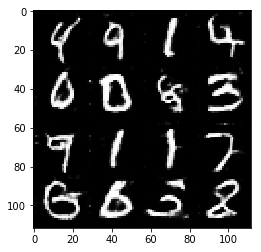

Epoch 2/2... Discriminator Loss: 1.3166 ... Generator Loss: 1.1489
Epoch 2/2... Discriminator Loss: 1.1845 ... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 1.6985 ... Generator Loss: 0.3590
Epoch 2/2... Discriminator Loss: 1.4129 ... Generator Loss: 0.4725
Epoch 2/2... Discriminator Loss: 1.1610 ... Generator Loss: 0.7390


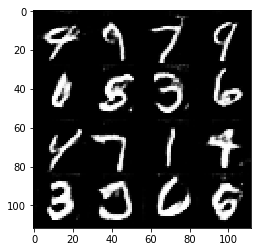

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1

# https://discussions.udacity.com/t/project-facegeneration-indexerror-list-index-out-of-range/246401
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4270 ... Generator Loss: 3.9751
Epoch 1/1... Discriminator Loss: 0.1636 ... Generator Loss: 5.8218
Epoch 1/1... Discriminator Loss: 0.2775 ... Generator Loss: 12.3603
Epoch 1/1... Discriminator Loss: 0.2709 ... Generator Loss: 20.4005
Epoch 1/1... Discriminator Loss: 0.1934 ... Generator Loss: 11.1873
Epoch 1/1... Discriminator Loss: 0.3479 ... Generator Loss: 8.5368
Epoch 1/1... Discriminator Loss: 0.2060 ... Generator Loss: 8.8196
Epoch 1/1... Discriminator Loss: 0.4407 ... Generator Loss: 22.1700
Epoch 1/1... Discriminator Loss: 0.2448 ... Generator Loss: 7.4836
Epoch 1/1... Discriminator Loss: 0.5249 ... Generator Loss: 3.1782


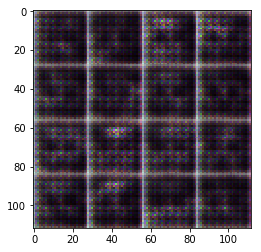

Epoch 1/1... Discriminator Loss: 1.0536 ... Generator Loss: 8.4750
Epoch 1/1... Discriminator Loss: 0.8146 ... Generator Loss: 4.2151
Epoch 1/1... Discriminator Loss: 0.6500 ... Generator Loss: 2.1596
Epoch 1/1... Discriminator Loss: 0.4991 ... Generator Loss: 1.9207
Epoch 1/1... Discriminator Loss: 0.3037 ... Generator Loss: 3.0839
Epoch 1/1... Discriminator Loss: 0.3827 ... Generator Loss: 5.5665
Epoch 1/1... Discriminator Loss: 0.4094 ... Generator Loss: 7.2111
Epoch 1/1... Discriminator Loss: 0.2926 ... Generator Loss: 5.3111
Epoch 1/1... Discriminator Loss: 0.3917 ... Generator Loss: 3.3603
Epoch 1/1... Discriminator Loss: 0.2853 ... Generator Loss: 6.3760


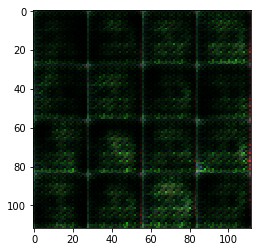

Epoch 1/1... Discriminator Loss: 0.3887 ... Generator Loss: 4.1130
Epoch 1/1... Discriminator Loss: 0.2890 ... Generator Loss: 5.9415
Epoch 1/1... Discriminator Loss: 0.4396 ... Generator Loss: 6.9469
Epoch 1/1... Discriminator Loss: 0.2832 ... Generator Loss: 6.9469
Epoch 1/1... Discriminator Loss: 0.3114 ... Generator Loss: 5.5682
Epoch 1/1... Discriminator Loss: 0.6788 ... Generator Loss: 3.4163
Epoch 1/1... Discriminator Loss: 0.8201 ... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 1.0888 ... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 0.7236 ... Generator Loss: 2.1536
Epoch 1/1... Discriminator Loss: 0.6970 ... Generator Loss: 2.2485


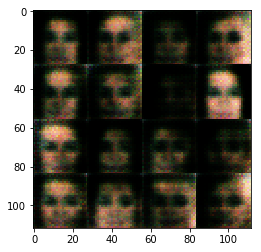

Epoch 1/1... Discriminator Loss: 0.4930 ... Generator Loss: 6.3211
Epoch 1/1... Discriminator Loss: 1.0113 ... Generator Loss: 6.1006
Epoch 1/1... Discriminator Loss: 0.3941 ... Generator Loss: 2.9818
Epoch 1/1... Discriminator Loss: 1.2685 ... Generator Loss: 1.9837
Epoch 1/1... Discriminator Loss: 0.6560 ... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 0.5462 ... Generator Loss: 2.1518
Epoch 1/1... Discriminator Loss: 0.8135 ... Generator Loss: 2.8778
Epoch 1/1... Discriminator Loss: 1.0819 ... Generator Loss: 4.8370
Epoch 1/1... Discriminator Loss: 0.8023 ... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.4279 ... Generator Loss: 5.6743


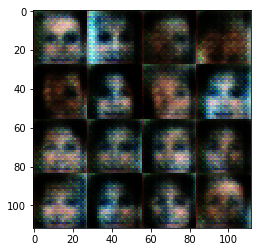

Epoch 1/1... Discriminator Loss: 1.4690 ... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.0604 ... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 0.4350 ... Generator Loss: 2.4214
Epoch 1/1... Discriminator Loss: 0.2759 ... Generator Loss: 5.7133
Epoch 1/1... Discriminator Loss: 0.5982 ... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 0.4396 ... Generator Loss: 2.4193
Epoch 1/1... Discriminator Loss: 0.4726 ... Generator Loss: 2.7210
Epoch 1/1... Discriminator Loss: 1.9400 ... Generator Loss: 0.3246
Epoch 1/1... Discriminator Loss: 0.4592 ... Generator Loss: 4.6398
Epoch 1/1... Discriminator Loss: 0.4302 ... Generator Loss: 4.2787


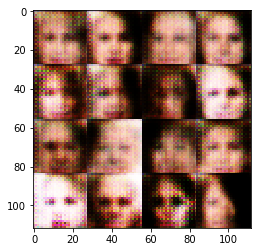

Epoch 1/1... Discriminator Loss: 0.5692 ... Generator Loss: 1.4914
Epoch 1/1... Discriminator Loss: 0.9307 ... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 1.1719 ... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 0.6148 ... Generator Loss: 1.7535
Epoch 1/1... Discriminator Loss: 0.3799 ... Generator Loss: 2.6935
Epoch 1/1... Discriminator Loss: 0.6469 ... Generator Loss: 1.5267
Epoch 1/1... Discriminator Loss: 1.3633 ... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 0.8898 ... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 0.8054 ... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 0.3119 ... Generator Loss: 6.4521


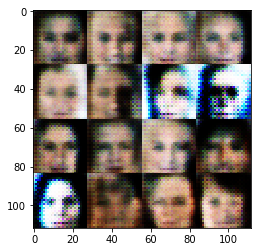

Epoch 1/1... Discriminator Loss: 1.6250 ... Generator Loss: 5.5018
Epoch 1/1... Discriminator Loss: 0.8885 ... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.4394 ... Generator Loss: 3.9152
Epoch 1/1... Discriminator Loss: 1.1140 ... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 0.5075 ... Generator Loss: 3.2099
Epoch 1/1... Discriminator Loss: 0.2966 ... Generator Loss: 3.7388
Epoch 1/1... Discriminator Loss: 0.5849 ... Generator Loss: 1.7961
Epoch 1/1... Discriminator Loss: 0.8255 ... Generator Loss: 4.0161
Epoch 1/1... Discriminator Loss: 0.2684 ... Generator Loss: 5.0088
Epoch 1/1... Discriminator Loss: 0.4182 ... Generator Loss: 3.2334


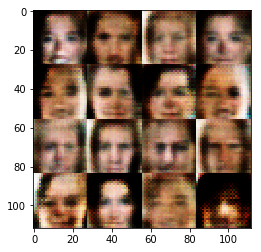

Epoch 1/1... Discriminator Loss: 0.4590 ... Generator Loss: 2.2654
Epoch 1/1... Discriminator Loss: 0.3927 ... Generator Loss: 3.3797
Epoch 1/1... Discriminator Loss: 1.4846 ... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 0.7797 ... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 0.7757 ... Generator Loss: 1.3230
Epoch 1/1... Discriminator Loss: 0.6959 ... Generator Loss: 1.8403
Epoch 1/1... Discriminator Loss: 0.7819 ... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 1.2724 ... Generator Loss: 4.5954
Epoch 1/1... Discriminator Loss: 1.0448 ... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 2.0448 ... Generator Loss: 0.5103


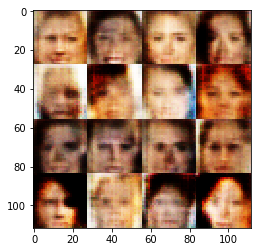

Epoch 1/1... Discriminator Loss: 0.5225 ... Generator Loss: 3.6476
Epoch 1/1... Discriminator Loss: 0.4867 ... Generator Loss: 2.3414
Epoch 1/1... Discriminator Loss: 0.6916 ... Generator Loss: 1.8427
Epoch 1/1... Discriminator Loss: 0.9230 ... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 1.1133 ... Generator Loss: 2.2996
Epoch 1/1... Discriminator Loss: 0.5561 ... Generator Loss: 1.6636
Epoch 1/1... Discriminator Loss: 0.9483 ... Generator Loss: 1.6313
Epoch 1/1... Discriminator Loss: 2.3694 ... Generator Loss: 0.2683
Epoch 1/1... Discriminator Loss: 0.7765 ... Generator Loss: 1.3825
Epoch 1/1... Discriminator Loss: 1.0581 ... Generator Loss: 0.9997


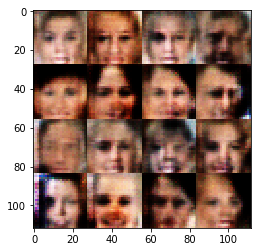

Epoch 1/1... Discriminator Loss: 1.0633 ... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 0.7888 ... Generator Loss: 1.5331
Epoch 1/1... Discriminator Loss: 0.7943 ... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 1.1331 ... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 0.8543 ... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 0.3859 ... Generator Loss: 3.2066
Epoch 1/1... Discriminator Loss: 0.3172 ... Generator Loss: 3.1057
Epoch 1/1... Discriminator Loss: 0.6562 ... Generator Loss: 2.0846
Epoch 1/1... Discriminator Loss: 1.0852 ... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 0.8705 ... Generator Loss: 1.4457


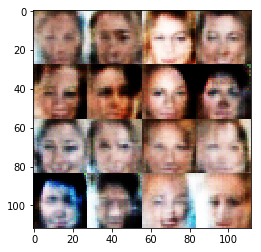

Epoch 1/1... Discriminator Loss: 0.5596 ... Generator Loss: 2.4131
Epoch 1/1... Discriminator Loss: 0.6313 ... Generator Loss: 1.7743
Epoch 1/1... Discriminator Loss: 0.9078 ... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 3.0402 ... Generator Loss: 5.1792
Epoch 1/1... Discriminator Loss: 0.6192 ... Generator Loss: 1.9766
Epoch 1/1... Discriminator Loss: 0.5040 ... Generator Loss: 1.9632
Epoch 1/1... Discriminator Loss: 0.8579 ... Generator Loss: 5.7134
Epoch 1/1... Discriminator Loss: 1.1365 ... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 0.9330 ... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.6213 ... Generator Loss: 1.9754


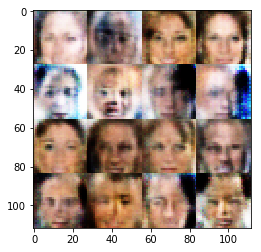

Epoch 1/1... Discriminator Loss: 0.3903 ... Generator Loss: 2.2882
Epoch 1/1... Discriminator Loss: 0.8377 ... Generator Loss: 3.9369
Epoch 1/1... Discriminator Loss: 0.7854 ... Generator Loss: 2.7024
Epoch 1/1... Discriminator Loss: 0.5074 ... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 0.8792 ... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 0.9952 ... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 0.9780 ... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.0998 ... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 0.7099 ... Generator Loss: 1.7124
Epoch 1/1... Discriminator Loss: 1.1927 ... Generator Loss: 0.7856


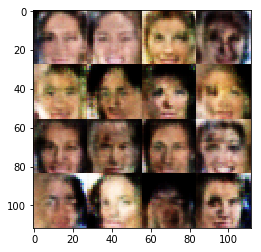

Epoch 1/1... Discriminator Loss: 0.8941 ... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 0.9072 ... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 0.6366 ... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 2.4591 ... Generator Loss: 3.0283
Epoch 1/1... Discriminator Loss: 0.8033 ... Generator Loss: 2.0441
Epoch 1/1... Discriminator Loss: 0.4344 ... Generator Loss: 1.9824
Epoch 1/1... Discriminator Loss: 1.3579 ... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.1034 ... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.1524 ... Generator Loss: 3.2394
Epoch 1/1... Discriminator Loss: 1.4216 ... Generator Loss: 2.7720


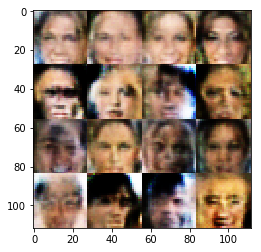

Epoch 1/1... Discriminator Loss: 0.9501 ... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.7109 ... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 0.9046 ... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 0.7103 ... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.4045 ... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.0863 ... Generator Loss: 2.7929
Epoch 1/1... Discriminator Loss: 1.1360 ... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 0.7125 ... Generator Loss: 2.6016
Epoch 1/1... Discriminator Loss: 0.5322 ... Generator Loss: 2.9812
Epoch 1/1... Discriminator Loss: 0.8030 ... Generator Loss: 1.2392


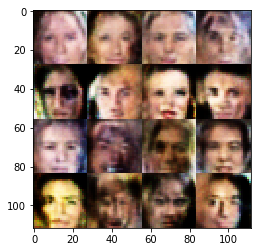

Epoch 1/1... Discriminator Loss: 1.5421 ... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 0.8949 ... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.2721 ... Generator Loss: 2.4378
Epoch 1/1... Discriminator Loss: 0.9301 ... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.1685 ... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 0.8545 ... Generator Loss: 1.2818
Epoch 1/1... Discriminator Loss: 0.6122 ... Generator Loss: 2.4201
Epoch 1/1... Discriminator Loss: 1.0961 ... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 1.0759 ... Generator Loss: 3.2403
Epoch 1/1... Discriminator Loss: 1.0455 ... Generator Loss: 1.0720


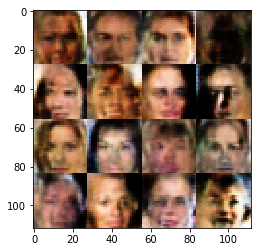

Epoch 1/1... Discriminator Loss: 1.0972 ... Generator Loss: 2.8079
Epoch 1/1... Discriminator Loss: 1.0842 ... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.2609 ... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.1445 ... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 0.6436 ... Generator Loss: 2.4418
Epoch 1/1... Discriminator Loss: 1.4279 ... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 0.7538 ... Generator Loss: 1.9660
Epoch 1/1... Discriminator Loss: 0.3945 ... Generator Loss: 2.3311
Epoch 1/1... Discriminator Loss: 1.0034 ... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 0.5476 ... Generator Loss: 2.1932


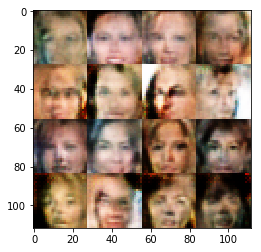

Epoch 1/1... Discriminator Loss: 0.4819 ... Generator Loss: 2.8552
Epoch 1/1... Discriminator Loss: 1.9305 ... Generator Loss: 0.3499
Epoch 1/1... Discriminator Loss: 1.1995 ... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.0634 ... Generator Loss: 1.5481
Epoch 1/1... Discriminator Loss: 1.1969 ... Generator Loss: 1.4865
Epoch 1/1... Discriminator Loss: 1.0627 ... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 0.6463 ... Generator Loss: 2.4716
Epoch 1/1... Discriminator Loss: 1.2875 ... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.0049 ... Generator Loss: 2.4054
Epoch 1/1... Discriminator Loss: 0.9022 ... Generator Loss: 1.4219


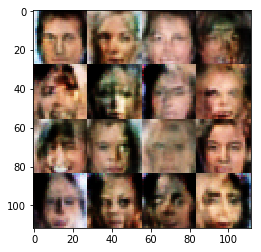

Epoch 1/1... Discriminator Loss: 0.5428 ... Generator Loss: 1.5377
Epoch 1/1... Discriminator Loss: 0.5702 ... Generator Loss: 4.4963
Epoch 1/1... Discriminator Loss: 2.0922 ... Generator Loss: 0.2581
Epoch 1/1... Discriminator Loss: 0.6614 ... Generator Loss: 4.0193
Epoch 1/1... Discriminator Loss: 0.7579 ... Generator Loss: 1.3150
Epoch 1/1... Discriminator Loss: 0.9563 ... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.7153 ... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 0.5776 ... Generator Loss: 1.9980
Epoch 1/1... Discriminator Loss: 0.6777 ... Generator Loss: 3.7469
Epoch 1/1... Discriminator Loss: 1.1988 ... Generator Loss: 0.7862


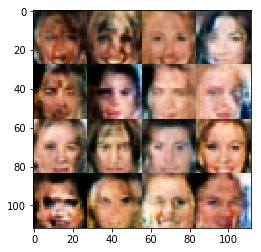

Epoch 1/1... Discriminator Loss: 1.1827 ... Generator Loss: 1.3222
Epoch 1/1... Discriminator Loss: 0.6474 ... Generator Loss: 1.8454
Epoch 1/1... Discriminator Loss: 0.7685 ... Generator Loss: 1.6060
Epoch 1/1... Discriminator Loss: 0.7776 ... Generator Loss: 1.5910
Epoch 1/1... Discriminator Loss: 0.6811 ... Generator Loss: 2.0485
Epoch 1/1... Discriminator Loss: 1.4516 ... Generator Loss: 2.9650
Epoch 1/1... Discriminator Loss: 0.7986 ... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 0.8285 ... Generator Loss: 1.5888
Epoch 1/1... Discriminator Loss: 1.5383 ... Generator Loss: 1.8823
Epoch 1/1... Discriminator Loss: 1.0097 ... Generator Loss: 1.5920


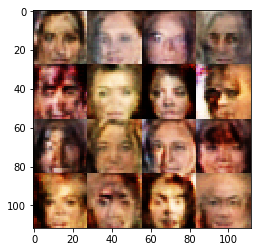

Epoch 1/1... Discriminator Loss: 0.9039 ... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.9724 ... Generator Loss: 2.2619
Epoch 1/1... Discriminator Loss: 1.1014 ... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 0.8415 ... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 0.6641 ... Generator Loss: 2.0051
Epoch 1/1... Discriminator Loss: 1.0704 ... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 0.6777 ... Generator Loss: 1.5002
Epoch 1/1... Discriminator Loss: 1.0446 ... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.2143 ... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.0098 ... Generator Loss: 1.5820


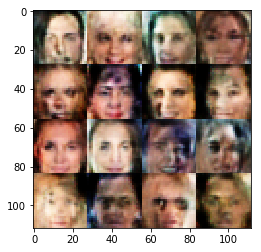

Epoch 1/1... Discriminator Loss: 0.4130 ... Generator Loss: 3.3513
Epoch 1/1... Discriminator Loss: 0.6136 ... Generator Loss: 1.8523
Epoch 1/1... Discriminator Loss: 1.0543 ... Generator Loss: 1.4564
Epoch 1/1... Discriminator Loss: 0.7633 ... Generator Loss: 2.6250
Epoch 1/1... Discriminator Loss: 0.9647 ... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 0.8123 ... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 1.1978 ... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.6895 ... Generator Loss: 1.7232
Epoch 1/1... Discriminator Loss: 0.6314 ... Generator Loss: 2.3686
Epoch 1/1... Discriminator Loss: 1.0299 ... Generator Loss: 0.6722


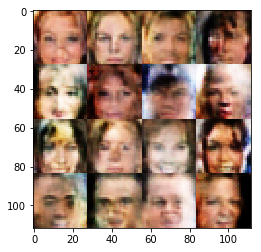

Epoch 1/1... Discriminator Loss: 0.9056 ... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.0833 ... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.1492 ... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4884 ... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 0.7978 ... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.0176 ... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 0.3697 ... Generator Loss: 3.7240
Epoch 1/1... Discriminator Loss: 1.1709 ... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 1.1206 ... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 0.8846 ... Generator Loss: 1.0719


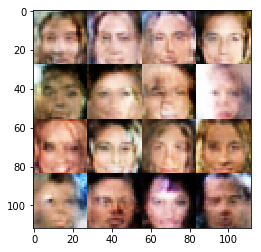

Epoch 1/1... Discriminator Loss: 0.8935 ... Generator Loss: 1.8792
Epoch 1/1... Discriminator Loss: 1.0663 ... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 0.7261 ... Generator Loss: 2.6444
Epoch 1/1... Discriminator Loss: 1.2687 ... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 0.8439 ... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 0.7065 ... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 0.9887 ... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 0.8546 ... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 0.9903 ... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 0.8086 ... Generator Loss: 0.8907


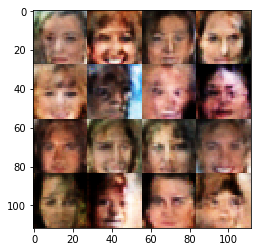

Epoch 1/1... Discriminator Loss: 0.8473 ... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.0367 ... Generator Loss: 2.4086
Epoch 1/1... Discriminator Loss: 0.6406 ... Generator Loss: 1.7565
Epoch 1/1... Discriminator Loss: 0.5735 ... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 1.7298 ... Generator Loss: 0.3160
Epoch 1/1... Discriminator Loss: 1.1700 ... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.0741 ... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 0.8928 ... Generator Loss: 1.8450
Epoch 1/1... Discriminator Loss: 1.0781 ... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 0.9423 ... Generator Loss: 0.9808


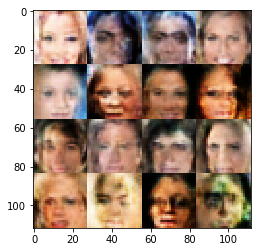

Epoch 1/1... Discriminator Loss: 0.8866 ... Generator Loss: 1.7841
Epoch 1/1... Discriminator Loss: 0.7682 ... Generator Loss: 1.9073
Epoch 1/1... Discriminator Loss: 0.7249 ... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 1.4613 ... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.0272 ... Generator Loss: 1.5839
Epoch 1/1... Discriminator Loss: 0.7411 ... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 0.7851 ... Generator Loss: 1.6237
Epoch 1/1... Discriminator Loss: 1.7997 ... Generator Loss: 0.3294
Epoch 1/1... Discriminator Loss: 1.2327 ... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 0.5583 ... Generator Loss: 2.3159


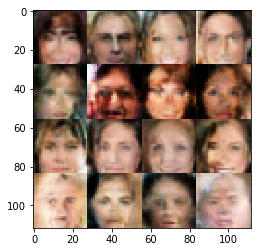

Epoch 1/1... Discriminator Loss: 1.2084 ... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 0.9508 ... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.0366 ... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 1.0053 ... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.1095 ... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 0.9983 ... Generator Loss: 1.4373
Epoch 1/1... Discriminator Loss: 1.2537 ... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 0.9898 ... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.1544 ... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 0.8835 ... Generator Loss: 1.0476


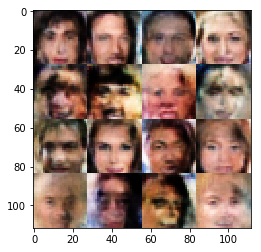

Epoch 1/1... Discriminator Loss: 1.1748 ... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 2.7756 ... Generator Loss: 3.0327
Epoch 1/1... Discriminator Loss: 1.4200 ... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 0.7374 ... Generator Loss: 1.5462
Epoch 1/1... Discriminator Loss: 0.9795 ... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 0.4648 ... Generator Loss: 2.7775
Epoch 1/1... Discriminator Loss: 0.7663 ... Generator Loss: 1.6833
Epoch 1/1... Discriminator Loss: 0.9936 ... Generator Loss: 1.3011
Epoch 1/1... Discriminator Loss: 1.0090 ... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 0.6417 ... Generator Loss: 1.2235


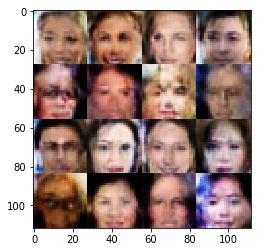

Epoch 1/1... Discriminator Loss: 0.9480 ... Generator Loss: 1.8334
Epoch 1/1... Discriminator Loss: 0.8772 ... Generator Loss: 2.0349
Epoch 1/1... Discriminator Loss: 1.2854 ... Generator Loss: 1.6043
Epoch 1/1... Discriminator Loss: 0.6970 ... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 1.0173 ... Generator Loss: 1.8741
Epoch 1/1... Discriminator Loss: 1.0804 ... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 0.9518 ... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 0.8392 ... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 0.7268 ... Generator Loss: 3.5363
Epoch 1/1... Discriminator Loss: 0.9632 ... Generator Loss: 1.0374


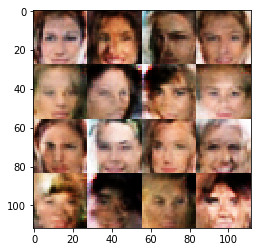

Epoch 1/1... Discriminator Loss: 0.7931 ... Generator Loss: 1.2363
Epoch 1/1... Discriminator Loss: 0.9769 ... Generator Loss: 1.4994
Epoch 1/1... Discriminator Loss: 0.3898 ... Generator Loss: 1.9593
Epoch 1/1... Discriminator Loss: 0.7431 ... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 0.5427 ... Generator Loss: 2.7861
Epoch 1/1... Discriminator Loss: 0.5460 ... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 0.9022 ... Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 2.0119 ... Generator Loss: 0.3131
Epoch 1/1... Discriminator Loss: 1.3099 ... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.2272 ... Generator Loss: 0.6662


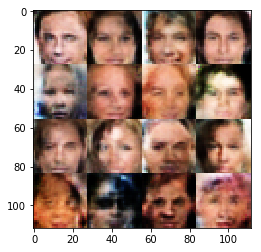

Epoch 1/1... Discriminator Loss: 0.5798 ... Generator Loss: 2.2133
Epoch 1/1... Discriminator Loss: 0.6814 ... Generator Loss: 1.4398
Epoch 1/1... Discriminator Loss: 0.9282 ... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.2770 ... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 0.7327 ... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 0.6816 ... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 0.8180 ... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.0999 ... Generator Loss: 2.5875
Epoch 1/1... Discriminator Loss: 1.1426 ... Generator Loss: 2.0212
Epoch 1/1... Discriminator Loss: 0.8060 ... Generator Loss: 2.5259


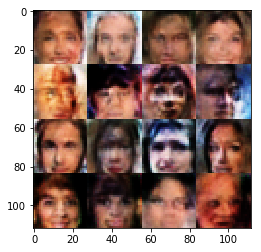

Epoch 1/1... Discriminator Loss: 0.6440 ... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 0.9304 ... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 0.8131 ... Generator Loss: 3.5726
Epoch 1/1... Discriminator Loss: 0.7920 ... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.0075 ... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 1.0641 ... Generator Loss: 1.9220
Epoch 1/1... Discriminator Loss: 1.2733 ... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 0.6775 ... Generator Loss: 1.4904
Epoch 1/1... Discriminator Loss: 0.8842 ... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.0869 ... Generator Loss: 0.7729


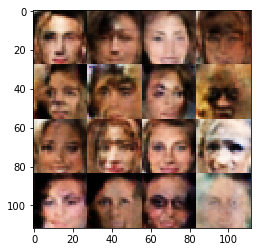

Epoch 1/1... Discriminator Loss: 1.0267 ... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 0.7478 ... Generator Loss: 1.7964
Epoch 1/1... Discriminator Loss: 0.4727 ... Generator Loss: 2.8747
Epoch 1/1... Discriminator Loss: 0.4708 ... Generator Loss: 3.2789
Epoch 1/1... Discriminator Loss: 1.2224 ... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.6202 ... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 0.6466 ... Generator Loss: 2.3426
Epoch 1/1... Discriminator Loss: 1.8398 ... Generator Loss: 1.7243
Epoch 1/1... Discriminator Loss: 1.3530 ... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 1.1497 ... Generator Loss: 1.3942


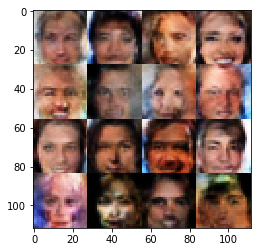

Epoch 1/1... Discriminator Loss: 0.8943 ... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 0.5174 ... Generator Loss: 1.9564
Epoch 1/1... Discriminator Loss: 0.7452 ... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 1.3978 ... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 0.9229 ... Generator Loss: 2.8234
Epoch 1/1... Discriminator Loss: 0.5717 ... Generator Loss: 1.9199
Epoch 1/1... Discriminator Loss: 0.8960 ... Generator Loss: 1.5787
Epoch 1/1... Discriminator Loss: 0.6227 ... Generator Loss: 2.0246
Epoch 1/1... Discriminator Loss: 0.9377 ... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.2990 ... Generator Loss: 0.4436


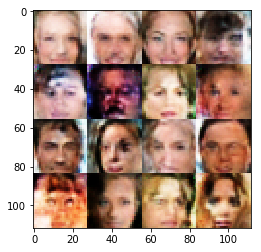

Epoch 1/1... Discriminator Loss: 0.9455 ... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.0147 ... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 0.8910 ... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 0.5924 ... Generator Loss: 2.2069
Epoch 1/1... Discriminator Loss: 0.7391 ... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 0.8958 ... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.4966 ... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.1355 ... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.1365 ... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 1.0513 ... Generator Loss: 0.6757


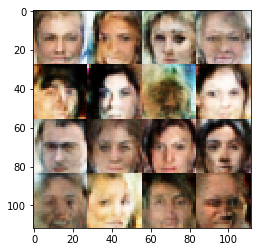

Epoch 1/1... Discriminator Loss: 1.5668 ... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 0.7450 ... Generator Loss: 1.6238
Epoch 1/1... Discriminator Loss: 1.0806 ... Generator Loss: 1.5730
Epoch 1/1... Discriminator Loss: 1.8091 ... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.3338 ... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 0.7610 ... Generator Loss: 1.6758
Epoch 1/1... Discriminator Loss: 1.1867 ... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 0.9327 ... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 0.9564 ... Generator Loss: 1.7422
Epoch 1/1... Discriminator Loss: 0.8933 ... Generator Loss: 1.1076


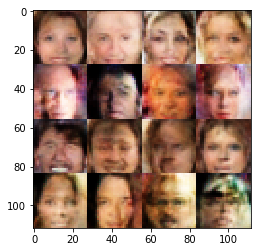

Epoch 1/1... Discriminator Loss: 1.2982 ... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.0330 ... Generator Loss: 1.6836
Epoch 1/1... Discriminator Loss: 0.5939 ... Generator Loss: 2.5590
Epoch 1/1... Discriminator Loss: 1.5801 ... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 0.5786 ... Generator Loss: 2.5580
Epoch 1/1... Discriminator Loss: 1.0974 ... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 0.6158 ... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.8378 ... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 1.0042 ... Generator Loss: 2.1176
Epoch 1/1... Discriminator Loss: 0.7418 ... Generator Loss: 2.4152


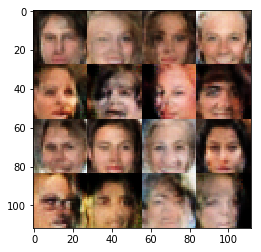

Epoch 1/1... Discriminator Loss: 0.8815 ... Generator Loss: 1.5089
Epoch 1/1... Discriminator Loss: 1.2381 ... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.1553 ... Generator Loss: 1.8377
Epoch 1/1... Discriminator Loss: 0.9726 ... Generator Loss: 1.4012
Epoch 1/1... Discriminator Loss: 0.8639 ... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 0.8637 ... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.2035 ... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 1.1101 ... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.0224 ... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.0647 ... Generator Loss: 0.6520


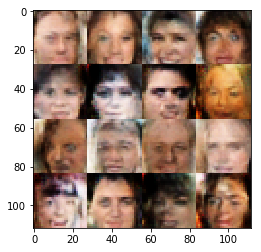

Epoch 1/1... Discriminator Loss: 1.2715 ... Generator Loss: 3.9417
Epoch 1/1... Discriminator Loss: 1.0118 ... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.8401 ... Generator Loss: 1.5583
Epoch 1/1... Discriminator Loss: 0.9588 ... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 0.8110 ... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 1.0364 ... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 0.8107 ... Generator Loss: 1.2419
Epoch 1/1... Discriminator Loss: 1.5122 ... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 0.9446 ... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 0.8437 ... Generator Loss: 1.7615


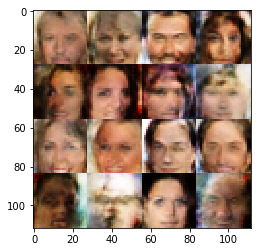

Epoch 1/1... Discriminator Loss: 1.0543 ... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.2853 ... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.2882 ... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 0.6501 ... Generator Loss: 1.7982
Epoch 1/1... Discriminator Loss: 0.6087 ... Generator Loss: 2.5392
Epoch 1/1... Discriminator Loss: 0.9108 ... Generator Loss: 1.8185
Epoch 1/1... Discriminator Loss: 1.2142 ... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 0.8645 ... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.0044 ... Generator Loss: 3.1112
Epoch 1/1... Discriminator Loss: 1.8219 ... Generator Loss: 0.3859


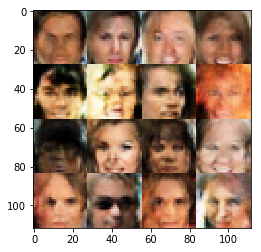

Epoch 1/1... Discriminator Loss: 0.7035 ... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.9308 ... Generator Loss: 0.3399
Epoch 1/1... Discriminator Loss: 0.8063 ... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 1.2342 ... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 0.7327 ... Generator Loss: 1.4923
Epoch 1/1... Discriminator Loss: 0.7640 ... Generator Loss: 1.4245
Epoch 1/1... Discriminator Loss: 0.9651 ... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 0.9325 ... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 0.5646 ... Generator Loss: 2.0667
Epoch 1/1... Discriminator Loss: 0.8934 ... Generator Loss: 0.7258


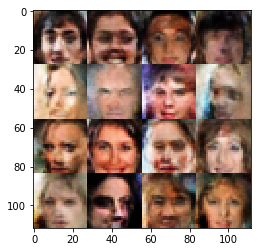

Epoch 1/1... Discriminator Loss: 0.4228 ... Generator Loss: 2.4819
Epoch 1/1... Discriminator Loss: 0.6299 ... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 1.8504 ... Generator Loss: 2.4789
Epoch 1/1... Discriminator Loss: 0.7667 ... Generator Loss: 4.3222
Epoch 1/1... Discriminator Loss: 1.4272 ... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 0.9599 ... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 0.9596 ... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 0.7930 ... Generator Loss: 1.5426
Epoch 1/1... Discriminator Loss: 0.9756 ... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 0.7696 ... Generator Loss: 1.4639


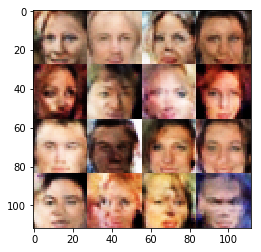

Epoch 1/1... Discriminator Loss: 0.9129 ... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 0.7843 ... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.3240 ... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 0.7245 ... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 0.9013 ... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 0.9944 ... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 0.7498 ... Generator Loss: 1.7771
Epoch 1/1... Discriminator Loss: 0.7453 ... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 1.5773 ... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 0.8911 ... Generator Loss: 0.9731


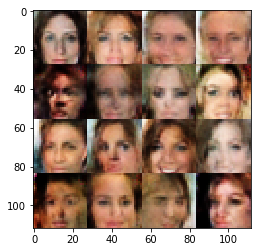

Epoch 1/1... Discriminator Loss: 0.6306 ... Generator Loss: 1.6538
Epoch 1/1... Discriminator Loss: 0.7675 ... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 0.5169 ... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 1.0925 ... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.0816 ... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 2.0724 ... Generator Loss: 0.2714
Epoch 1/1... Discriminator Loss: 0.7520 ... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.7894 ... Generator Loss: 1.4642
Epoch 1/1... Discriminator Loss: 0.8273 ... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.4389 ... Generator Loss: 2.2127


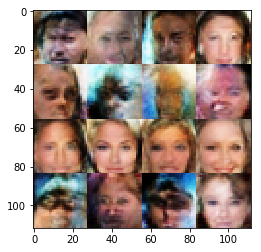

Epoch 1/1... Discriminator Loss: 0.9097 ... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.3473 ... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.0519 ... Generator Loss: 2.0984
Epoch 1/1... Discriminator Loss: 0.5334 ... Generator Loss: 2.3348
Epoch 1/1... Discriminator Loss: 0.6631 ... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 0.9615 ... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.1489 ... Generator Loss: 1.9666
Epoch 1/1... Discriminator Loss: 0.8872 ... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 0.7929 ... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 0.6688 ... Generator Loss: 2.6583


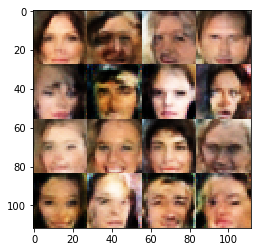

Epoch 1/1... Discriminator Loss: 1.4141 ... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.0339 ... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.0968 ... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 0.9746 ... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 1.0395 ... Generator Loss: 1.4519
Epoch 1/1... Discriminator Loss: 1.1251 ... Generator Loss: 1.4373
Epoch 1/1... Discriminator Loss: 0.6257 ... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.1877 ... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 0.6309 ... Generator Loss: 1.9572
Epoch 1/1... Discriminator Loss: 0.5007 ... Generator Loss: 2.6962


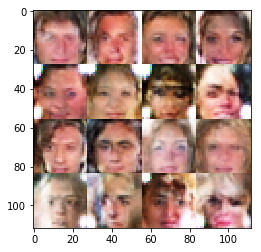

Epoch 1/1... Discriminator Loss: 0.3044 ... Generator Loss: 3.7337
Epoch 1/1... Discriminator Loss: 0.7180 ... Generator Loss: 1.2313
Epoch 1/1... Discriminator Loss: 0.7026 ... Generator Loss: 1.9060
Epoch 1/1... Discriminator Loss: 0.4665 ... Generator Loss: 1.8612
Epoch 1/1... Discriminator Loss: 0.6121 ... Generator Loss: 1.8401
Epoch 1/1... Discriminator Loss: 0.4986 ... Generator Loss: 4.2187
Epoch 1/1... Discriminator Loss: 0.3823 ... Generator Loss: 3.7824
Epoch 1/1... Discriminator Loss: 0.4230 ... Generator Loss: 3.5066
Epoch 1/1... Discriminator Loss: 0.6008 ... Generator Loss: 1.7600
Epoch 1/1... Discriminator Loss: 0.8940 ... Generator Loss: 1.1816


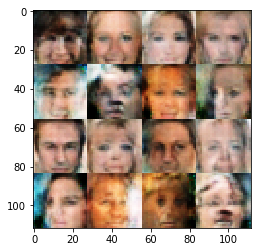

Epoch 1/1... Discriminator Loss: 0.7366 ... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 0.7107 ... Generator Loss: 1.5447
Epoch 1/1... Discriminator Loss: 1.4198 ... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.1517 ... Generator Loss: 1.6594
Epoch 1/1... Discriminator Loss: 1.0015 ... Generator Loss: 1.4173
Epoch 1/1... Discriminator Loss: 1.0566 ... Generator Loss: 1.4185
Epoch 1/1... Discriminator Loss: 0.6500 ... Generator Loss: 1.4737
Epoch 1/1... Discriminator Loss: 1.2437 ... Generator Loss: 1.3758
Epoch 1/1... Discriminator Loss: 1.4647 ... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.3717 ... Generator Loss: 0.5492


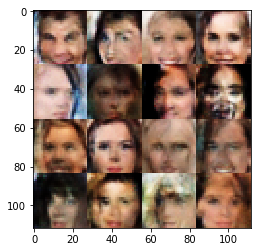

Epoch 1/1... Discriminator Loss: 0.7133 ... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 0.3970 ... Generator Loss: 4.2894
Epoch 1/1... Discriminator Loss: 0.7975 ... Generator Loss: 1.3267
Epoch 1/1... Discriminator Loss: 1.3645 ... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.1668 ... Generator Loss: 1.6868
Epoch 1/1... Discriminator Loss: 1.0464 ... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 0.6429 ... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 2.8247 ... Generator Loss: 4.1498
Epoch 1/1... Discriminator Loss: 1.3562 ... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 0.9971 ... Generator Loss: 1.8074


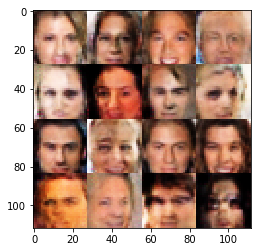

Epoch 1/1... Discriminator Loss: 1.2878 ... Generator Loss: 1.4517
Epoch 1/1... Discriminator Loss: 0.9277 ... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.1116 ... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 1.9627 ... Generator Loss: 0.3442
Epoch 1/1... Discriminator Loss: 0.8382 ... Generator Loss: 2.1319
Epoch 1/1... Discriminator Loss: 0.7745 ... Generator Loss: 2.2306
Epoch 1/1... Discriminator Loss: 0.6347 ... Generator Loss: 1.8961
Epoch 1/1... Discriminator Loss: 1.0189 ... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 0.6466 ... Generator Loss: 2.1674
Epoch 1/1... Discriminator Loss: 0.7294 ... Generator Loss: 4.1701


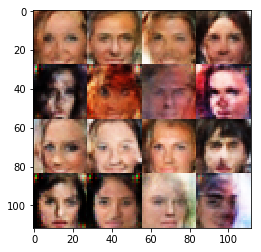

Epoch 1/1... Discriminator Loss: 1.0555 ... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 0.7776 ... Generator Loss: 1.3280
Epoch 1/1... Discriminator Loss: 0.7578 ... Generator Loss: 1.8930
Epoch 1/1... Discriminator Loss: 0.7152 ... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 1.3125 ... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 0.9493 ... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.1352 ... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 0.6915 ... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 0.6019 ... Generator Loss: 1.5298
Epoch 1/1... Discriminator Loss: 0.9121 ... Generator Loss: 1.1878


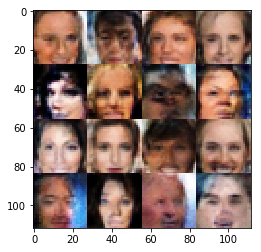

Epoch 1/1... Discriminator Loss: 0.7472 ... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 1.0557 ... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 0.8791 ... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.0229 ... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 0.4800 ... Generator Loss: 2.6566
Epoch 1/1... Discriminator Loss: 1.3029 ... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 1.1665 ... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 2.0010 ... Generator Loss: 0.3534
Epoch 1/1... Discriminator Loss: 1.0827 ... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 0.8561 ... Generator Loss: 1.4276


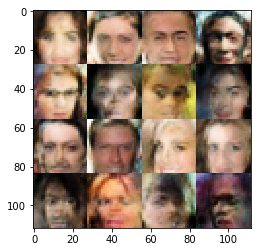

Epoch 1/1... Discriminator Loss: 1.1826 ... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.0327 ... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.6471 ... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 1.1688 ... Generator Loss: 1.6454
Epoch 1/1... Discriminator Loss: 1.0308 ... Generator Loss: 1.4372
Epoch 1/1... Discriminator Loss: 0.8754 ... Generator Loss: 1.7630
Epoch 1/1... Discriminator Loss: 0.7216 ... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 0.9147 ... Generator Loss: 1.8004
Epoch 1/1... Discriminator Loss: 1.0994 ... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 0.9155 ... Generator Loss: 1.0218


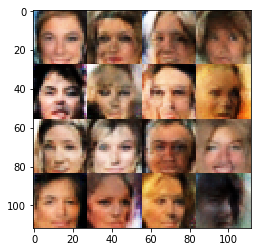

Epoch 1/1... Discriminator Loss: 0.9680 ... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 0.4771 ... Generator Loss: 2.6109
Epoch 1/1... Discriminator Loss: 1.4444 ... Generator Loss: 1.7027
Epoch 1/1... Discriminator Loss: 1.0088 ... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 0.7830 ... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 0.8126 ... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 0.8846 ... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 0.9016 ... Generator Loss: 1.3758
Epoch 1/1... Discriminator Loss: 1.2731 ... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 0.9394 ... Generator Loss: 0.9118


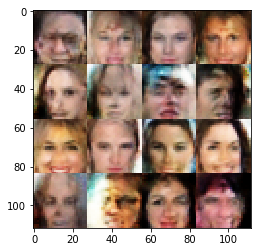

Epoch 1/1... Discriminator Loss: 1.2553 ... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 0.4796 ... Generator Loss: 1.6754
Epoch 1/1... Discriminator Loss: 1.3001 ... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 2.0835 ... Generator Loss: 0.2772
Epoch 1/1... Discriminator Loss: 0.7615 ... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 1.2596 ... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 1.1496 ... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 1.1999 ... Generator Loss: 3.0250
Epoch 1/1... Discriminator Loss: 0.9792 ... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 0.9514 ... Generator Loss: 1.8938


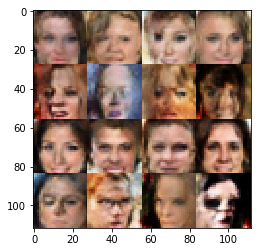

Epoch 1/1... Discriminator Loss: 1.0944 ... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.0666 ... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 0.9190 ... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.4683 ... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 0.8416 ... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 0.9734 ... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 0.7914 ... Generator Loss: 2.0507
Epoch 1/1... Discriminator Loss: 0.9603 ... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 1.6240 ... Generator Loss: 0.3646
Epoch 1/1... Discriminator Loss: 1.0772 ... Generator Loss: 0.6372


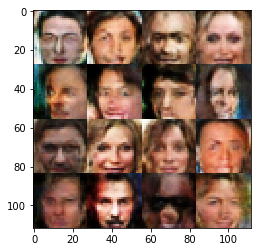

Epoch 1/1... Discriminator Loss: 1.1581 ... Generator Loss: 2.5424
Epoch 1/1... Discriminator Loss: 0.9290 ... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 0.9285 ... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 0.7907 ... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 1.0775 ... Generator Loss: 3.2709
Epoch 1/1... Discriminator Loss: 0.8713 ... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 0.9651 ... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.0061 ... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.0461 ... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.2029 ... Generator Loss: 0.6739


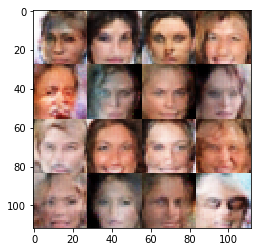

Epoch 1/1... Discriminator Loss: 0.5626 ... Generator Loss: 2.8963
Epoch 1/1... Discriminator Loss: 1.1192 ... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 0.9690 ... Generator Loss: 2.3677
Epoch 1/1... Discriminator Loss: 0.8059 ... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.1799 ... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.1808 ... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.0604 ... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 1.1032 ... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 0.8560 ... Generator Loss: 2.7035
Epoch 1/1... Discriminator Loss: 1.0144 ... Generator Loss: 0.9066


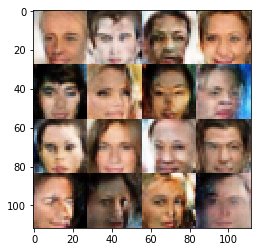

Epoch 1/1... Discriminator Loss: 0.9372 ... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 1.3005 ... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 0.4811 ... Generator Loss: 3.6684
Epoch 1/1... Discriminator Loss: 1.3649 ... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 0.9682 ... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 0.7134 ... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 1.3998 ... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 0.9753 ... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.8034 ... Generator Loss: 2.7917
Epoch 1/1... Discriminator Loss: 0.8820 ... Generator Loss: 1.1923


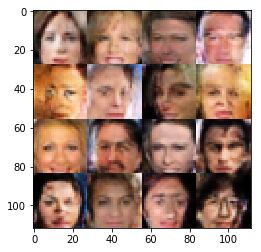

Epoch 1/1... Discriminator Loss: 1.3777 ... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 0.7429 ... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.1050 ... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 0.8221 ... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 1.4541 ... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 0.7925 ... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 0.9328 ... Generator Loss: 1.6151
Epoch 1/1... Discriminator Loss: 1.0584 ... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.1614 ... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.0650 ... Generator Loss: 1.4738


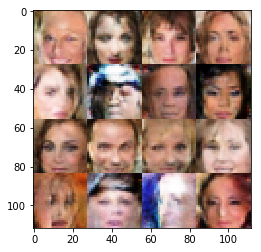

Epoch 1/1... Discriminator Loss: 1.1200 ... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 0.7480 ... Generator Loss: 1.5125
Epoch 1/1... Discriminator Loss: 0.8669 ... Generator Loss: 1.5755
Epoch 1/1... Discriminator Loss: 0.7142 ... Generator Loss: 1.8052
Epoch 1/1... Discriminator Loss: 0.9417 ... Generator Loss: 2.3816
Epoch 1/1... Discriminator Loss: 1.1349 ... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.2906 ... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.2103 ... Generator Loss: 1.2984
Epoch 1/1... Discriminator Loss: 0.8765 ... Generator Loss: 1.3150
Epoch 1/1... Discriminator Loss: 0.9111 ... Generator Loss: 1.1773


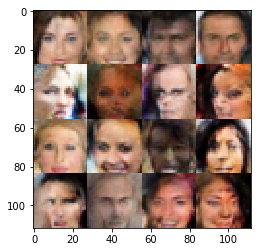

Epoch 1/1... Discriminator Loss: 1.1588 ... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 0.7902 ... Generator Loss: 1.3118
Epoch 1/1... Discriminator Loss: 1.1673 ... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.6362 ... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 0.9680 ... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.0230 ... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 0.4806 ... Generator Loss: 1.5774
Epoch 1/1... Discriminator Loss: 1.1357 ... Generator Loss: 2.3207
Epoch 1/1... Discriminator Loss: 0.9577 ... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 0.5865 ... Generator Loss: 1.9208


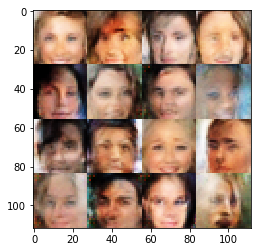

Epoch 1/1... Discriminator Loss: 0.6100 ... Generator Loss: 1.6752
Epoch 1/1... Discriminator Loss: 1.1551 ... Generator Loss: 2.1137
Epoch 1/1... Discriminator Loss: 0.9445 ... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 0.8337 ... Generator Loss: 1.4368
Epoch 1/1... Discriminator Loss: 1.2999 ... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 0.8970 ... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 0.7698 ... Generator Loss: 1.9521
Epoch 1/1... Discriminator Loss: 1.0508 ... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.7562 ... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 1.0349 ... Generator Loss: 0.9083


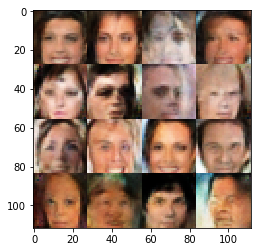

Epoch 1/1... Discriminator Loss: 1.1041 ... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.0821 ... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 0.6940 ... Generator Loss: 1.4135
Epoch 1/1... Discriminator Loss: 1.2031 ... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 0.9391 ... Generator Loss: 1.6435
Epoch 1/1... Discriminator Loss: 1.0376 ... Generator Loss: 2.3795
Epoch 1/1... Discriminator Loss: 1.2853 ... Generator Loss: 2.1711
Epoch 1/1... Discriminator Loss: 0.8764 ... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.0681 ... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.2009 ... Generator Loss: 0.6138


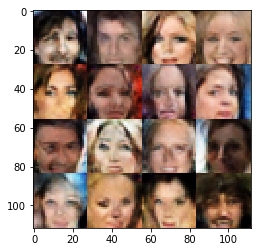

Epoch 1/1... Discriminator Loss: 0.7446 ... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 0.7240 ... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 1.2365 ... Generator Loss: 0.9192


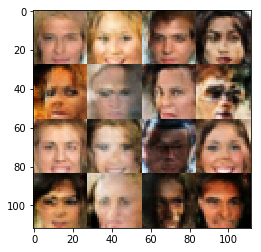

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.